<a href="https://colab.research.google.com/github/noambassat/Macabi_Home_Assignment/blob/main/macabi_home_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1100]:
pip install ydata-profiling --quiet

In [1101]:
pip install sweetviz --quiet

In [1102]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from ydata_profiling import ProfileReport
from sklearn.metrics import roc_auc_score

In [1103]:
df = pd.read_csv('ds_assignment_data.csv')
df.head()

,int_date,demog_capitationcoefficient,demog_customer_age,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers,lab_b_hcg_abs_last_value,lab_NT_MoM_last_value,lab_weight_at_lab_time_last_value,lab_num_of_fetuses_last_value,...,secondary_hypertension_sum,essential_hypertension_sum,hypertensive_heart_disease_sum,hypertensive_chronic_kidney_disease_sum,hypertensive_heart_and_chronic_kidney_disease_sum,pregnancy_hypertension_sum,preeclampsia_sum,eclampsia_sum,labs_sum,clinical_sheet
0,24163,0.73,33.0,0.0,0.00,0.0,44.9,1.01,90.0,1.0,...,0,0,0,0,0,0,0,0,0,שבוע 8\n\nתלונות: המטופלת מתלוננת על בחילות בב...
1,51373,0.79,34.0,1.0,1.86,0.0,31.6,0.80,58.0,1.0,...,0,0,0,0,0,0,0,0,0,שבוע 8 להיריון\n\nתלונות: המטופלת מתלוננת על ב...
2,74056,0.79,35.0,2.0,8.92,0.0,21.6,0.75,60.0,1.0,...,0,0,0,0,0,0,0,0,0,שבוע 8 להריון\n\nתלונות: המטופלת מתארת בחילות ...
3,57131,0.74,25.0,0.0,0.00,0.0,108.3,0.85,45.0,1.0,...,0,0,0,0,0,0,0,0,0,שבוע 8 להריון\n\nתלונות: \nהמטופלת בת 28 מגיעה...
4,89933,0.79,35.0,0.0,0.00,0.0,20.1,1.32,72.0,1.0,...,0,0,0,0,0,0,0,0,0,שבוע 8 להריון\n\nתלונות: המטופלת מדווחת על תחו...


In [1104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 157 entries, int_date to clinical_sheet
dtypes: float64(95), int64(61), object(1)
memory usage: 12.0+ MB


In [1105]:
for col in df.columns: print(col)

int_date
demog_capitationcoefficient
demog_customer_age
smoking_is_smoker
smoking_smoking_years
smoking_total_heavy_smokers
lab_b_hcg_abs_last_value
lab_NT_MoM_last_value
lab_weight_at_lab_time_last_value
lab_num_of_fetuses_last_value
lab_NT_abs_last_value
lab_papp_a_abs_last_value
lab_papp_a_MoM_last_value
lab_Protein-U_last_value
lab_Monocytes_1_last_value
lab_Mean Platelet Volume (MPV)_last_value
lab_Hemoglobin (HGB)_last_value
lab_Hematocrit (HCT)_last_value
lab_Red Blood Cells (RBC)_last_value
lab_Red Cell Count (RCC)_last_value
lab_Mean Corpuscular Hemoglobin (MCH)_last_value
lab_Mean Corpuscular Hemoglobin Concentration (MCHC)_last_value
lab_Red Cell Distribution Width (RDW)_last_value
lab_Platelets (PLT)_last_value
lab_Eosinophils_1_last_value
lab_White Blood Cells (WBC)_last_value
lab_Lymphocytes_1_last_value
lab_Neutrophils_1_last_value
lab_Eosinophils_2_last_value
lab_Basophils_1_last_value
lab_Neutrophils_2_last_value
lab_Lymphocytes_2_last_value
lab_Monocytes_2_last_value


In [1106]:
df["Y"].value_counts()

,count
Y,
0,9568
1,432


In [1107]:
df.dtypes.value_counts()

,count
float64,95
int64,61
object,1


In [1108]:

all_columns = df.columns.tolist()

group1 = []  # match_* columns
group2 = []  # *_sum columns
group3 = []  # everything else

for col in all_columns:
    if col.startswith("match_"):
        group1.append(col)
    elif col.endswith("_sum"):
        group2.append(col)
    else:
        group3.append(col)

# Group 3: divide by prefix
prefix_groups = defaultdict(list)
for col in group3:
    prefix = col.split("_")[0]
    prefix_groups[prefix].append(col)


print("== Group 1: Y and match_* columns ==")
for col in group1:
    print(f"  - {col}")

print("\n== Group 2: *_sum columns ==")
for col in group2:
    print(f"  - {col}")

print("\n== Group 3: All other columns grouped by prefix ==")

group_3_dict = {}
for prefix, cols in prefix_groups.items():
    print(f"{prefix} ({len(cols)}):")
    group_3_dict[prefix] = cols
    for col in cols:
        print(f"  - {col}")
    print()


== Group 1: Y and match_* columns ==
  - match_diag_141
  - match_measure_after
  - match_rasham_after
  - match_aspirin_after
  - match_pdf_after

== Group 2: *_sum columns ==
  - secondary_hypertension_sum
  - essential_hypertension_sum
  - hypertensive_heart_disease_sum
  - hypertensive_chronic_kidney_disease_sum
  - hypertensive_heart_and_chronic_kidney_disease_sum
  - pregnancy_hypertension_sum
  - preeclampsia_sum
  - eclampsia_sum
  - labs_sum

== Group 3: All other columns grouped by prefix ==
int (1):
  - int_date

demog (2):
  - demog_capitationcoefficient
  - demog_customer_age

smoking (3):
  - smoking_is_smoker
  - smoking_smoking_years
  - smoking_total_heavy_smokers

lab (27):
  - lab_b_hcg_abs_last_value
  - lab_NT_MoM_last_value
  - lab_weight_at_lab_time_last_value
  - lab_num_of_fetuses_last_value
  - lab_NT_abs_last_value
  - lab_papp_a_abs_last_value
  - lab_papp_a_MoM_last_value
  - lab_Protein-U_last_value
  - lab_Monocytes_1_last_value
  - lab_Mean Platelet Volu

In [1109]:
def initial_analysis(df: pd.DataFrame, group: list):

    display(df[group].info())

    drop_cols = []
    for col in group:
        print(f"\n=== {col} ===")
        vc = df[col].value_counts(dropna=False)
        display(vc)

        # Drop if only one unique value (constant)
        if df[col].nunique(dropna=False) == 1:
            drop_cols.append(col)

        # If continuous (numeric with many unique values), show stats
        elif pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique(dropna=False) > 10:
            print("\n[describe()]")
            display(df[col].describe())

    df.drop(columns=drop_cols, inplace=True)
    updated_group = [col for col in group if col not in drop_cols]

    return updated_group, drop_cols


### Group 1 - Target & Source Flags

In [1110]:
group1, drop_cols = initial_analysis(df, group1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   match_diag_141       10000 non-null  int64
 1   match_measure_after  10000 non-null  int64
 2   match_rasham_after   10000 non-null  int64
 3   match_aspirin_after  10000 non-null  int64
 4   match_pdf_after      10000 non-null  int64
dtypes: int64(5)
memory usage: 390.8 KB


None


=== match_diag_141 ===


,count
match_diag_141,
0,9713
1,287



=== match_measure_after ===


,count
match_measure_after,
0,10000



=== match_rasham_after ===


,count
match_rasham_after,
0,9984
1,16



=== match_aspirin_after ===


,count
match_aspirin_after,
0,9883
1,117



=== match_pdf_after ===


,count
match_pdf_after,
0,9888
1,112


In [1111]:
group1_counts = pd.DataFrame(df[group1+["Y"]].value_counts().sort_values(ascending=False))
group1_counts

count
match_diag_141 match_rasham_after match_aspirin_after match_pdf_after Y       
0              0                  0                   0               0   9568
1              0                  0                   0               1    206
0              0                  1                   0               1     93
1              0                  0                   1               1     48
0              0                  0                   1               1     47
1              0                  1                   0               1     13
               1                  0                   1               1      8
                                                      0               1      6
0              0                  1                   1               1      5
1              0                  1                   1               1      4
               1                  1                   0               1      2

In [1112]:
print(drop_cols)

['match_measure_after']


In [1113]:
# How many Y=1 have each match flag
df[df["Y"] == 1][group1].sum().sort_values()

,0
match_rasham_after,16
match_pdf_after,112
match_aspirin_after,117
match_diag_141,287


In [1114]:
# Count how many match_* flags each row has
df["match_count"] = df[group1[:-1]].sum(axis=1)

df[df["Y"] == 1]["match_count"].value_counts().sort_index()

,count
match_count,
0,47
1,352
2,31
3,2


In [1115]:
group1

['match_diag_141',
 'match_rasham_after',
 'match_aspirin_after',
 'match_pdf_after']

In [1116]:
# Check for Y=1 rows with no match flags
df["no_match"] = (df[group1].sum(axis=1) == 0)
df[df["Y"] == 1]["no_match"].sum()

np.int64(0)

In [1117]:
# Check for Y=0 rows with match flags
df[(df["Y"] == 0) & (df[group1[:-1]].sum(axis=1) > 0)]

,int_date,demog_capitationcoefficient,demog_customer_age,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers,lab_b_hcg_abs_last_value,lab_NT_MoM_last_value,lab_weight_at_lab_time_last_value,lab_num_of_fetuses_last_value,...,hypertensive_heart_disease_sum,hypertensive_chronic_kidney_disease_sum,hypertensive_heart_and_chronic_kidney_disease_sum,pregnancy_hypertension_sum,preeclampsia_sum,eclampsia_sum,labs_sum,clinical_sheet,match_count,no_match


In [1118]:
display(pd.DataFrame(df[group1+["match_count"]].value_counts()))

count
match_diag_141 match_rasham_after match_aspirin_after match_pdf_after match_count       
0              0                  0                   0               0             9568
1              0                  0                   0               1              206
0              0                  1                   0               1               93
1              0                  0                   1               1               48
0              0                  0                   1               0               47
1              0                  1                   0               2               13
               1                  0                   1               2                8
                                                      0               2                6
0              0                  1                   1               1                5
1              0                  1                   1               2                4
               1                  1                   0               3                2

Summary of Target & Source Flags (Group 1):

- Y = 1 in 432 patients.
- All patients with Y=1 have at least one match_* flag > 0, indicating consistent labeling with diagnosis sources.
- match_measure_after is always 0 and was removed from the dataset.
- There are no missing values in any of the Group 1 columns.
- Among Y=1 cases:
  - 346 patients have exactly one match_* source.
  - 72 have two match sources.
  - 14 have three match sources.
- No patients with Y=0 have any match_* flags set to 1, confirming that match flags only appear in positively labeled cases.


match_strength represents the number of different match_* sources (e.g., diagnosis, PDF, aspirin) that confirmed the hypertensive condition.

Higher values may indicate stronger clinical evidence or more severe cases.

### Group 2 - Diagnostic Subtype Counts

In [1119]:
group2, drop_cols = initial_analysis(df, group2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                                             Non-Null Count  Dtype
---  ------                                             --------------  -----
 0   secondary_hypertension_sum                         10000 non-null  int64
 1   essential_hypertension_sum                         10000 non-null  int64
 2   hypertensive_heart_disease_sum                     10000 non-null  int64
 3   hypertensive_chronic_kidney_disease_sum            10000 non-null  int64
 4   hypertensive_heart_and_chronic_kidney_disease_sum  10000 non-null  int64
 5   pregnancy_hypertension_sum                         10000 non-null  int64
 6   preeclampsia_sum                                   10000 non-null  int64
 7   eclampsia_sum                                      10000 non-null  int64
 8   labs_sum                                           10000 non-null  int64
dtypes: int64(9)
memory usage: 703.

None


=== secondary_hypertension_sum ===


,count
secondary_hypertension_sum,
0,10000



=== essential_hypertension_sum ===


,count
essential_hypertension_sum,
0,9900
1,100



=== hypertensive_heart_disease_sum ===


,count
hypertensive_heart_disease_sum,
0,10000



=== hypertensive_chronic_kidney_disease_sum ===


,count
hypertensive_chronic_kidney_disease_sum,
0,10000



=== hypertensive_heart_and_chronic_kidney_disease_sum ===


,count
hypertensive_heart_and_chronic_kidney_disease_sum,
0,10000



=== pregnancy_hypertension_sum ===


,count
pregnancy_hypertension_sum,
0,9889
1,111



=== preeclampsia_sum ===


,count
preeclampsia_sum,
0,9872
1,128



=== eclampsia_sum ===


,count
eclampsia_sum,
0,9983
1,17



=== labs_sum ===


,count
labs_sum,
0,9951
1,49


In [1120]:
# Count unique combinations of the group2 columns
value_counts_df = df[group2].value_counts().reset_index(name='count')

value_counts_df.sort_values(by='count', ascending=False).sort_values(by='eclampsia_sum', ascending=False)

,essential_hypertension_sum,pregnancy_hypertension_sum,preeclampsia_sum,eclampsia_sum,labs_sum,count
16,0,0,0,1,0,1
17,0,1,0,1,0,1
19,1,0,0,1,0,1
22,1,1,0,1,0,1
14,1,1,1,1,0,2
11,1,0,1,1,0,3
10,0,0,1,1,0,5
20,1,0,1,1,1,1
15,0,1,1,1,0,2
4,0,0,0,0,1,35


<Axes: >

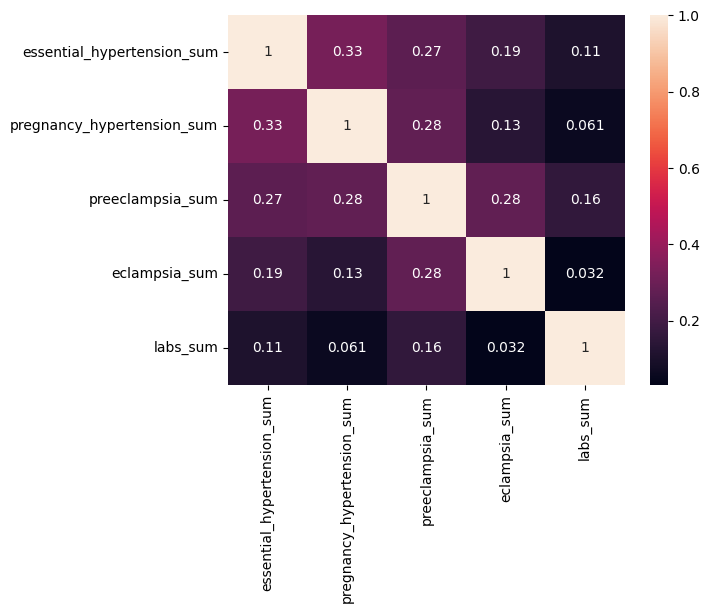

In [1121]:
group_2_corr = df[["essential_hypertension_sum", "pregnancy_hypertension_sum", "preeclampsia_sum", "eclampsia_sum", "labs_sum"]].corr().abs()
sns.heatmap(group_2_corr, annot=True)


1. טבלת צירופים (count)
רוב הנשים (9713 מתוך 10,000) לא קיבלו שום אבחנה (כל המשתנים בקבוצה 2 = 0).

המקרים הנפוצים ביותר בקרב Y=1 הם:

רק preeclampsia_sum = 1 (65 נשים)

רק pregnancy_hypertension_sum = 1 (53 נשים)

רק essential_hypertension_sum = 1 (45 נשים)

יש מיעוט קטן מאוד עם כמה אבחנות יחד (3 אבחנות ומעלה – רק בודדות).

labs_sum מופיע לבד ב־35 נשים – מעיד על ניטור, לא על חומרה גבוהה.

2. קורלציות
הקורלציות נמוכות עד בינוניות בין המשתנים – ולכן:

לא נזרוק משתנים בגלל תלות.

כן נוכל להשתמש גם בדרוג וגם בספירה (diagnosis_count).

In [1122]:
df[(df["pregnancy_hypertension_sum"]==1) & (df["essential_hypertension_sum"]==1)].shape[0] # how many womam are both ?

35

In [1123]:
drop_cols

['secondary_hypertension_sum',
 'hypertensive_heart_disease_sum',
 'hypertensive_chronic_kidney_disease_sum',
 'hypertensive_heart_and_chronic_kidney_disease_sum']

In [1124]:
df[(df["Y"] == 0) & (df[group2].sum(axis=1) > 0)]

,int_date,demog_capitationcoefficient,demog_customer_age,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers,lab_b_hcg_abs_last_value,lab_NT_MoM_last_value,lab_weight_at_lab_time_last_value,lab_num_of_fetuses_last_value,...,match_pdf_after,Y,essential_hypertension_sum,pregnancy_hypertension_sum,preeclampsia_sum,eclampsia_sum,labs_sum,clinical_sheet,match_count,no_match


#### Add new features

**severity_level**
0 = No diagnosis  
1 = labs_sum  
2 = essential_hypertension  
3 = pregnancy_hypertension  
4 = preeclampsia  
5 = eclampsia

**diagnosis_count**
How many different diagnosis appeared

In [1125]:
def get_severity_level(row):
    if row["eclampsia_sum"] == 1:
        return 5
    elif row["preeclampsia_sum"] == 1:
        return 4
    elif row["pregnancy_hypertension_sum"] == 1:
        return 3
    elif row["essential_hypertension_sum"] == 1:
        return 2
    elif row["labs_sum"] == 1:
        return 1
    else:
        return 0


df["severity_level"] = df.apply(get_severity_level, axis=1)

df["diagnosis_count"] = df[group2].sum(axis=1)

df["severity_score"] = df["severity_level"] + df["diagnosis_count"]


In [1126]:
severity_and_diagnosis_counts = pd.DataFrame(df[["severity_level","diagnosis_count", "severity_score","match_diag_141"]].value_counts().sort_values(ascending=False))
severity_and_diagnosis_counts

,,,,count
severity_level,diagnosis_count,severity_score,match_diag_141,
0,0,0,0,9713
4,1,5,1,65
3,1,4,1,53
2,1,3,1,45
4,2,6,1,36
1,1,2,1,35
3,2,5,1,21
4,3,7,1,11
5,2,7,1,7


In [1127]:
df.groupby("severity_level")["match_diag_141"].value_counts()

,,count
severity_level,match_diag_141,
0,0,9713
1,1,35
2,1,45
3,1,75
4,1,115
5,1,17


In [1128]:
df.groupby("severity_level")["Y"].value_counts()

severity_level  Y
0               0    9568
                1     145
1               1      35
2               1      45
3               1      75
4               1     115
5               1      17
Name: count, dtype: int64

In [1129]:
df[(df["Y"] == 1) & (df["severity_score"] == 0.0)][["match_aspirin_after", "match_pdf_after", "match_rasham_after"]].sum()

,0
match_aspirin_after,98
match_pdf_after,52
match_rasham_after,0


In [1130]:
df["match_counts"] = df[["match_aspirin_after", "match_pdf_after", "match_rasham_after"]].sum(axis=1) # for later analysis

All 145 cases of Y=1 and severity_score=1, came from match_aspirin_after and/or match_pdf_after. None came from "match_rasham_after", that means its not so informative feature as independant one.

In [1131]:
# group1.remove("match_rasham_after") ###

In [1132]:
df.groupby("severity_score")["match_diag_141"].value_counts()

,,count
severity_score,match_diag_141,
0,0,9713
2,1,35
3,1,45
4,1,53
5,1,86
6,1,38
7,1,18
8,1,9
9,1,3


In [1133]:
roc_auc_score(df["Y"], df["severity_score"])

np.float64(0.8321759259259259)

In [1134]:
roc_auc_score(df["match_diag_141"], df["severity_score"])

np.float64(1.0)

 Group 2 קובצה בהצלחה לפיצ’ר משמעותי אחד (או שניים).

התייחסות ל־Group 1:
גם כאן אפשר לשמור רק את:

Y — התוצאה המרכזית.

match_pdf_after — מקור רפואי חזק.

match_aspirin_after — סמן מניעתי/מנהלי.

ולזרוק את rasham (לא תורם מידע עצמאי).

match_diag_141 לא נדרש — חופף ל־severity_score.

מסקנה:

ה־severity_score מנבא בדיוק מושלם את match_diag_141.

משמע: כל מי שיש לה אבחנה קלינית (match_diag=1) מופיעה גם ב־severity_score > 0.

המשמעות: אפשר לזרוק את match_diag_141 בניתוחים – הוא לא מוסיף כלום.



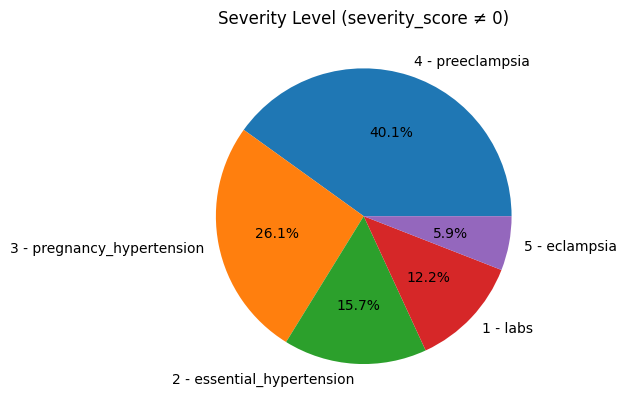

In [1135]:
severity_labels = {
    1: '1 - labs',
    2: '2 - essential_hypertension',
    3: '3 - pregnancy_hypertension',
    4: '4 - preeclampsia',
    5: '5 - eclampsia'
}

df_sev = df[df['severity_score'] != 0]['severity_level'].map(severity_labels)

df_sev.value_counts().plot(
    kind='pie',
    title='Severity Level (severity_score ≠ 0)',
    autopct='%1.1f%%'
)

plt.ylabel('')
plt.show()


In [1136]:
df[["severity_level", "diagnosis_count", "severity_score","Y","match_diag_141"]].corr()

,severity_level,diagnosis_count,severity_score,Y,match_diag_141
severity_level,1.000000,0.912682,0.990931,0.759585,0.938952
diagnosis_count,0.912682,1.000000,0.959320,0.722159,0.892688
severity_score,0.990931,0.959320,1.000000,0.762198,0.942182
Y,0.759585,0.722159,0.762198,1.000000,0.808971
match_diag_141,0.938952,0.892688,0.942182,0.808971,1.000000


<Axes: >

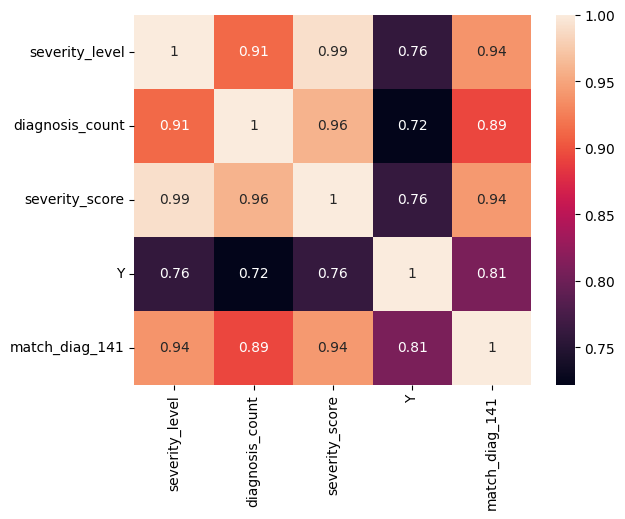

In [1137]:
sns.heatmap(df[["severity_level", "diagnosis_count", "severity_score","Y","match_diag_141"]].corr(), annot=True)

שלושת המשתנים נותנים אותו מידע כמעט.

severity_score כמעט זהה ל־severity_level בקורלציה, וה־AUC זהה.

In [1138]:
roc_auc_score(df["match_diag_141"], df["severity_level"])


np.float64(1.0)

In [1139]:
roc_auc_score(df["match_diag_141"], df["diagnosis_count"])


np.float64(1.0)

In [1140]:
roc_auc_score(df["match_diag_141"], df["severity_score"])

np.float64(1.0)

In [1141]:
df.groupby(["severity_level", "diagnosis_count"])["match_diag_141"].mean()


severity_level  diagnosis_count
0               0                  0.0
1               1                  1.0
2               1                  1.0
3               1                  1.0
                2                  1.0
                3                  1.0
4               1                  1.0
                2                  1.0
                3                  1.0
                4                  1.0
5               1                  1.0
                2                  1.0
                3                  1.0
                4                  1.0
Name: match_diag_141, dtype: float64

match_diag=1 מופיע רק כשיש חומרה (severity ≥ 1).

במצבים של severity=0 → רק aspirin ו־PDF מתעדים Y.

מסקנה:
severity_level מתאר באופן מדויק את תיעוד האבחנה ב־match_diag.

אפשר להסתמך עליו כייצוג אמין של חומרה קלינית.

Although a composite feature severity_score was initially constructed by combining severity_level with diagnosis_count, further analysis showed that it did not provide additional predictive value.
The correlation between severity_score and Y was nearly identical to that of severity_level alone (AUC = 0.83), and diagnosis_count did not meaningfully differentiate risk within severity groups.
As a result, only severity_level was retained for downstream analysis and interpretation, as it offers a clear, clinically grounded representation of hypertensive disorder severity.

In [1142]:
cols_to_drop = group2 + ["severity_score","diagnosis_count"]
group1 = group1 + ["severity_level","match_counts"]

In [1143]:
group1

['match_diag_141',
 'match_rasham_after',
 'match_aspirin_after',
 'match_pdf_after',
 'severity_level',
 'match_counts']

In [1144]:
df.drop(cols_to_drop,axis = 1,inplace=True)

In [1145]:
df[group1].value_counts()

match_diag_141  match_rasham_after  match_aspirin_after  match_pdf_after  severity_level  match_counts
0               0                   0                    0                0               0               9568
                                    1                    0                0               1                 93
1               0                   0                    0                4               0                 80
0               0                   0                    1                0               1                 47
1               0                   0                    0                3               0                 46
                                                                          1               0                 35
                                                                          2               0                 33
                                                         1                4               1                 24
                                                                          3               1                 17
                                                         0                5               0                 12
0               0                   1                    1                0               2                  5
1               0                   1                    0                3               1                  5
                                    0                    1                2               1                  4
                                    1                    0                4               1                  4
                                    0                    1                5               1                  3
                                    1                    0                2               1                  3
                1                   0                    1                4               2                  3
                                                                          3               2                  3
                                                         0                3               1                  2
                                                                          4               1                  2
                0                   1                    1                3               2                  2
                1                   0                    1                2               2                  2
                0                   1                    1                4               2                  1
                                                                          2               2                  1
                                                         0                5               1                  1
                1                   0                    0                2               1                  1
                                                                          5               1                  1
                                    1                    0                2               2                  1
                                                                          4               2                  1
Name: count, dtype: int64

In [1146]:
# report = ProfileReport(clean_df[group1+["Y"]], title="EDA Report", explorative=True)
# report.to_notebook_iframe()

### Group3 - Features by Group

In [1147]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# def eda_by_prefix(df, prefix, target="Y"):
#     group_cols = [col for col in df.columns if col.startswith(prefix)]
#     for col in group_cols:
#         print(f"Analyzing: {col}")
#         series = df[col]
#         dtype = series.dtype
#         missing_pct = series.isna().mean() * 100
#         nunique = series.nunique(dropna=False)

#         print(f"Missing: {missing_pct:.2f}%")
#         print(f"Data type: {dtype}")

#         if pd.api.types.is_numeric_dtype(series):
#             if nunique <= 10 or dtype == "int":
#                 print(f"Unique values: {nunique}")
#                 print(f"Values: {series.unique()}")
#                 print(f"Value counts:")
#                 print(series.value_counts(dropna=False))
#                 sns.countplot(data=df, x=col, hue=target)
#                 plt.title(f"{col} countplot")
#                 plt.show()
#             else:
#                 display(df[col].describe())
#                 sns.histplot(data=df, x=col, hue=target, bins=30, kde=True)
#                 plt.title(f"{col} histogram by {target}")
#                 plt.show()

#                 if pd.api.types.is_float_dtype(series) or nunique > 10:
#                     sns.boxplot(data=df, x=target, y=col)
#                     plt.title(f"{col} boxplot by {target}")
#                     plt.show()

#         elif pd.api.types.is_categorical_dtype(series) or pd.api.types.is_object_dtype(series):
#             if nunique <= 20:
#                 sns.countplot(data=df, x=col, hue=target)
#                 plt.title(f"{col} countplot")
#                 plt.xticks(rotation=45)
#                 plt.show()

#         if pd.api.types.is_numeric_dtype(series) and pd.api.types.is_numeric_dtype(df[target]):
#             correlation = df[[col, target]].dropna().corr().iloc[0, 1]
#             print(f"Correlation with {target}: {correlation:.3f}")

#         print("-" * 50)


In [1148]:
# def classify_features(df):
#     feature_info = []

#     for col in df.columns:
#         dtype = df[col].dtype
#         missing_pct = df[col].isna().mean()
#         nunique = df[col].nunique()
#         is_numeric = pd.api.types.is_numeric_dtype(df[col])
#         is_categorical = pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == 'object'

#         category = None
#         if nunique <= 1:
#             category = 'constant'
#         elif missing_pct > 0.95:
#             category = 'sparse'
#         elif is_numeric and nunique > 20:
#             category = 'numeric'
#         elif is_categorical and nunique <= 20:
#             category = 'categorical'
#         elif is_numeric and nunique <= 20:
#             category = 'discrete'
#         else:
#             category = 'other'

#         feature_info.append({
#             "feature": col,
#             "dtype": str(dtype),
#             "missing_pct": round(missing_pct * 100, 1),
#             "n_unique": nunique,
#             "category": category
#         })

#     return pd.DataFrame(feature_info)


In [1149]:
def countplot_with_percentages(df, col, target='Y'):
    ax = sns.countplot(data=df, x=col, hue=target)
    plt.title(f"{col} countplot with Y breakdown")

    # calculate percentages
    total = df.groupby(col)[target].value_counts(normalize=True).unstack().fillna(0)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            group = p.get_x() + p.get_width() / 2
            x_val = round(p.get_x() + p.get_width() / 2, 2)
            y_val = p.get_y() + height
            cat = int(p.get_x())
            label = f"{height:.0f}"
            plt.text(x=x_val, y=y_val + 30, s=label, ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()


def classify_and_eda(df, target="Y", prefix=None, plot=True):
    features = group3
    if prefix:
        features = [col for col in df.columns if col.startswith(prefix)]

    results = []

    for col in features:

        series = df[col]
        dtype = series.dtype
        missing_pct = series.isna().mean()
        nunique = series.nunique(dropna=False)
        is_numeric = pd.api.types.is_numeric_dtype(series)
        is_categorical = pd.api.types.is_categorical_dtype(series) or dtype == 'object'

        # initial classification
        if nunique <= 1:
            category = "constant"
        elif missing_pct > 0.95:
            category = "sparse"
        elif is_numeric and nunique > 20:
            category = "numeric"
        elif is_numeric and nunique <= 20:
            category = "discrete"
        elif is_categorical and nunique <= 20:
            category = "categorical"
        else:
            category = "other"

        # print textual info
        print(f"--- Analyzing: {col} ---")
        print(f"Missing: {missing_pct:.1%}")
        print(f"Unique: {nunique}")
        print(f"Type: {dtype}")
        print(f"Category: {category}")

        # eda by category
        if plot and category in ["discrete", "categorical"]:
          countplot_with_percentages(df, col)

        elif plot and category == "numeric":
            display(series.describe())
            sns.histplot(data=df, x=col, hue=target, bins=30, kde=True)
            plt.title(f"{col} histogram by {target}")
            plt.show()

            sns.boxplot(data=df, x=target, y=col)
            plt.title(f"{col} boxplot by {target}")
            plt.show()


        correlation = None
        if is_numeric and pd.api.types.is_numeric_dtype(df[target]):
            try:
                correlation = df[[col, target]].dropna().corr().iloc[0, 1]
                print(f"Correlation with {target}: {correlation:.3f}")
            except:
                correlation = None

        results.append({
            "feature": col,
            "dtype": str(dtype),
            "missing_pct": round(missing_pct * 100, 1),
            "n_unique": nunique,
            "category": category,
            "correlation_with_target": round(correlation, 3) if correlation is not None else None
        })

        print("-" * 60)

    return pd.DataFrame(results)


In [1150]:
group_3_dict.keys()

dict_keys(['int', 'demog', 'smoking', 'lab', 'measure', '24', '4', 'Y', 'clinical'])

#### Smoking Analysis

In [1151]:
smoking_cols = group_3_dict["smoking"]

In [1152]:
df[smoking_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   smoking_is_smoker            6731 non-null   float64
 1   smoking_smoking_years        6731 non-null   float64
 2   smoking_total_heavy_smokers  6731 non-null   float64
dtypes: float64(3)
memory usage: 234.5 KB


In [1153]:
df[smoking_cols].describe()

,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers
count,6731.000000,6731.000000,6731.000000
mean,0.522953,4.004316,0.013074
std,0.684926,16.410500,0.205008
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,2.415000,0.000000
max,2.000000,122.940000,9.000000


In [1154]:
df['smoking_is_smoker'].value_counts(dropna=False)

,count
smoking_is_smoker,
0.0,3950
NaN,3269
1.0,2042
2.0,739


In [1155]:
df['smoking_is_smoker'] = df['smoking_is_smoker'].astype('category')

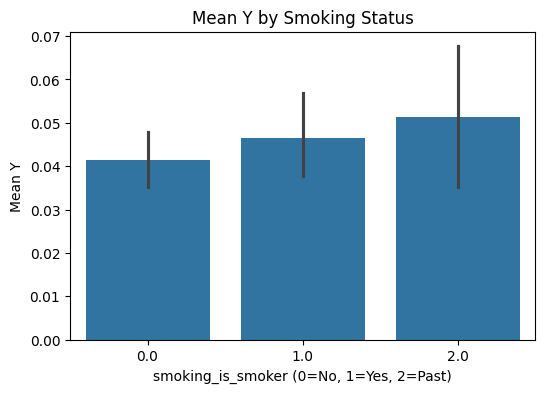

In [1156]:
plt.figure(figsize=(6,4))
sns.barplot(x='smoking_is_smoker', y='Y', data=df)
plt.title('Mean Y by Smoking Status')
plt.xlabel('smoking_is_smoker (0=No, 1=Yes, 2=Past)')
plt.ylabel('Mean Y')
plt.show()

In [1157]:
df[df['smoking_smoking_years'] > 40][['smoking_smoking_years']].shape[0]

140

140 נשים הריניות שמעשנות מעל 40 שנה ? לא הגיוני וזה ערך חריג\טעות

In [1158]:
df.groupby('smoking_is_smoker')['smoking_smoking_years'].describe()

<ipython-input-1158-59fe0f9e8dcb>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('smoking_is_smoker')['smoking_smoking_years'].describe()


,count,mean,std,min,25%,50%,75%,max
smoking_is_smoker,,,,,,,,
0.0,3950.0,0.000000,0.000000,0.0,0.00,0.00,0.000,0.00
1.0,2042.0,10.370970,25.241140,0.0,1.51,3.92,7.430,122.94
2.0,739.0,7.815332,21.939396,0.0,0.00,2.28,6.355,120.86


In [1159]:
df['smoking_total_heavy_smokers'].value_counts().sort_index()

,count
smoking_total_heavy_smokers,
0.0,6683
1.0,31
2.0,9
3.0,2
4.0,2
5.0,2
6.0,1
9.0,1


In [1160]:
df.groupby('smoking_is_smoker')['smoking_total_heavy_smokers'].mean()

<ipython-input-1160-da2822e021fe>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('smoking_is_smoker')['smoking_total_heavy_smokers'].mean()


,smoking_total_heavy_smokers
smoking_is_smoker,
0.0,0.000506
1.0,0.018609
2.0,0.064953


In [1161]:
df.groupby(df['smoking_total_heavy_smokers'] > 0)['Y'].mean()

,Y
smoking_total_heavy_smokers,
False,0.043308
True,0.020833


In [1162]:
df[(df['smoking_is_smoker'] != 0) & (df['smoking_smoking_years'] == 0)][smoking_cols]

,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers
69,2.0,0.0,0.0
79,2.0,0.0,0.0
167,2.0,0.0,0.0
236,2.0,0.0,0.0
294,2.0,0.0,0.0
...,...,...,...
9655,2.0,0.0,0.0
9808,2.0,0.0,0.0
9827,1.0,0.0,0.0
9874,2.0,0.0,0.0


מה המשמעות?
מדובר על 257 נשים שמדווחות כמעשנות בעבר או בהווה, אבל לכאורה עישנו אפס שנים.

מתוך 257:

רובן עם smoking_is_smoker == 2.0 → כנראה דיווח לקוי של מעשנות בעבר שלא מסרו משך עישון.

מעטות עם smoking_is_smoker == 1.0 → זו כבר סתירה חמורה יותר.

In [1163]:
df[(df['smoking_is_smoker'].isna()) & (~df['smoking_smoking_years'].isna())][smoking_cols]

,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers


In [1164]:
df[(df['smoking_is_smoker'] == 0) & (df['smoking_smoking_years'] != 0)][smoking_cols]

,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers


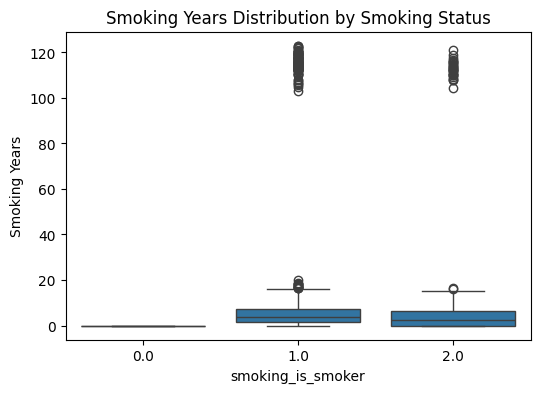

In [1165]:
plt.figure(figsize=(6,4))
sns.boxplot(x='smoking_is_smoker', y='smoking_smoking_years', data=df)
plt.title('Smoking Years Distribution by Smoking Status')
plt.xlabel('smoking_is_smoker')
plt.ylabel('Smoking Years')
plt.show()

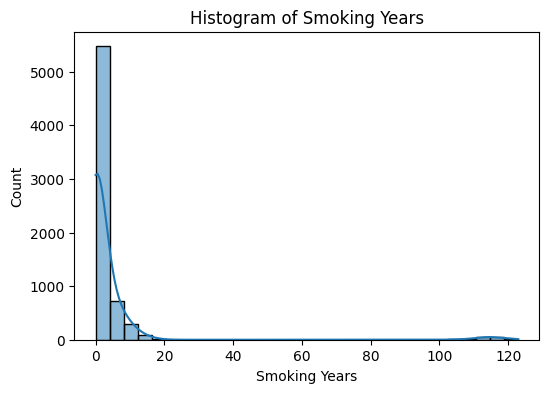

In [1166]:
plt.figure(figsize=(6,4))
sns.histplot(df['smoking_smoking_years'].dropna(), bins=30, kde=True)
plt.title('Histogram of Smoking Years')
plt.xlabel('Smoking Years')
plt.ylabel('Count')
plt.show()

##### handle smoking:


אפשר לנסות לחלץ משמעותיות עישון מהטקסט החופשי של הרופא, אבל כיוון שהקורלציה בין המשתנים האלה למשתנה המטרה כשלעצמה מאוד נמוכה, אטפל בזה כרגע בצורה נאיבית.

מעל 40 שנות עישון זה לא הגיוני לנשים בהריון, הן מקסימום בנות 45, ולא מעשנות מגיל 5, ככה שגם 40 זה טווח מוגדל

In [1167]:
df.loc[df['smoking_smoking_years'] > 50, 'smoking_smoking_years'] = np.nan

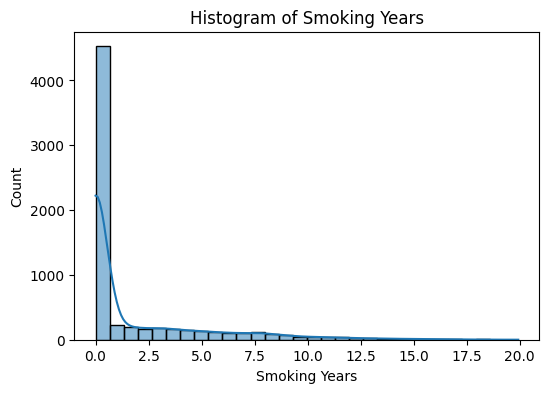

In [1168]:
plt.figure(figsize=(6,4))
sns.histplot(df['smoking_smoking_years'].dropna(), bins=30, kde=True)
plt.title('Histogram of Smoking Years')
plt.xlabel('Smoking Years')
plt.ylabel('Count')
plt.show()

In [1098]:
df.loc[(df['smoking_is_smoker'].isin([1, 2])) & (df['smoking_smoking_years'] == 0), 'smoking_smoking_years'] = np.nan

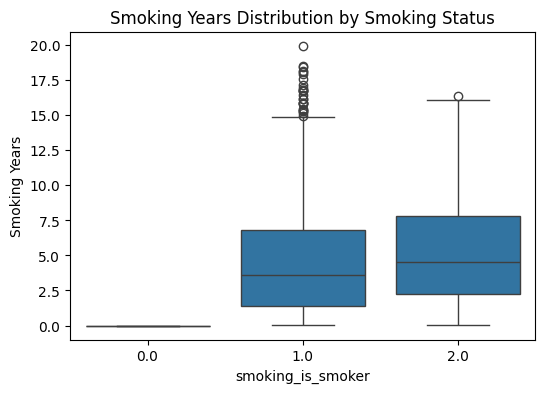

In [1099]:
plt.figure(figsize=(6,4))
sns.boxplot(x='smoking_is_smoker', y='smoking_smoking_years', data=df)
plt.title('Smoking Years Distribution by Smoking Status')
plt.xlabel('smoking_is_smoker')
plt.ylabel('Smoking Years')
plt.show()

In [952]:
df['int_date'].describe()

,int_date
count,10000.000000
mean,45231.350200
std,26278.437077
min,43.000000
25%,22503.250000
50%,45409.500000
75%,68150.750000
max,90265.000000


Analyzing: smoking_is_smoker
Missing: 32.69%
Data type: float64
Unique values: 4
Values: [ 0.  1.  2. nan]
Value counts:
smoking_is_smoker
0.0    3950
NaN    3269
1.0    2042
2.0     739
Name: count, dtype: int64


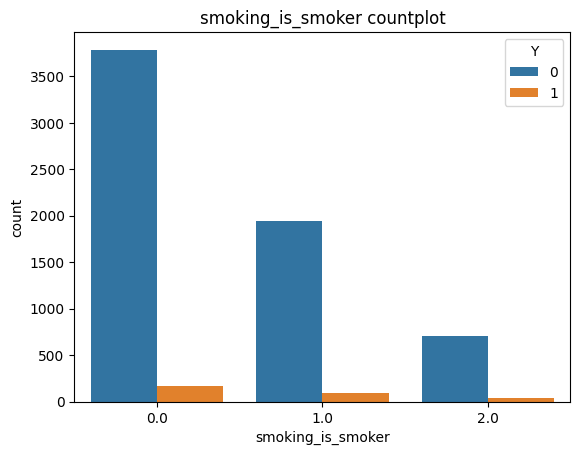

Correlation with Y: 0.017
--------------------------------------------------
Analyzing: smoking_smoking_years
Missing: 32.69%
Data type: float64


,smoking_smoking_years
count,6731.000000
mean,4.004316
std,16.410500
min,0.000000
25%,0.000000
50%,0.000000
75%,2.415000
max,122.940000


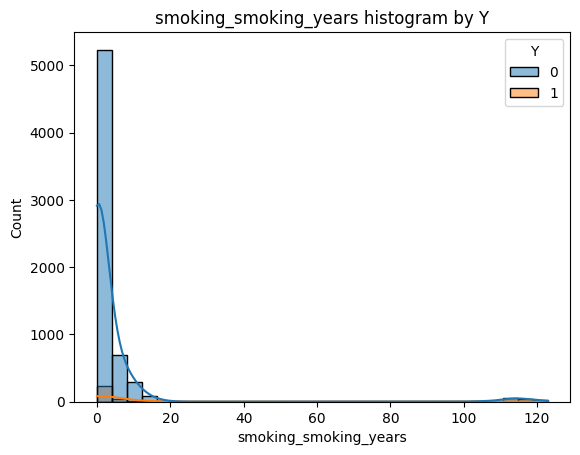

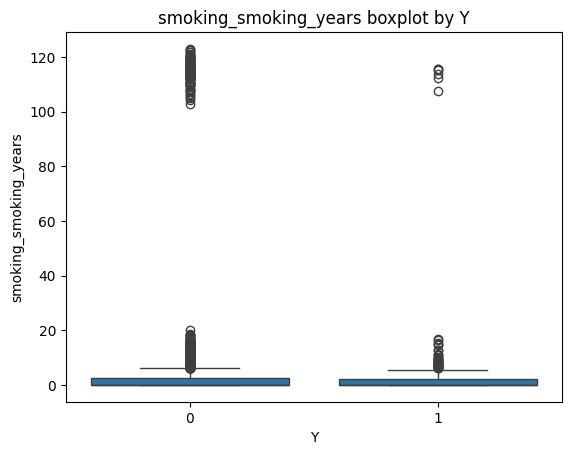

Correlation with Y: 0.001
--------------------------------------------------
Analyzing: smoking_total_heavy_smokers
Missing: 32.69%
Data type: float64
Unique values: 9
Values: [ 0. nan  1.  2.  3.  6.  5.  4.  9.]
Value counts:
smoking_total_heavy_smokers
0.0    6683
NaN    3269
1.0      31
2.0       9
3.0       2
5.0       2
4.0       2
6.0       1
9.0       1
Name: count, dtype: int64


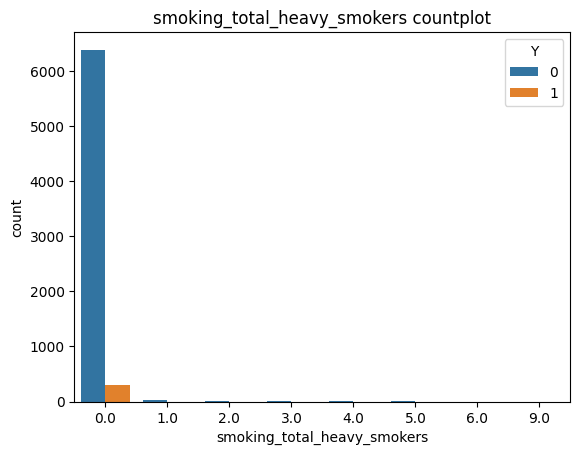

Correlation with Y: -0.007
--------------------------------------------------


In [946]:
print(classify_features(df[group3]))

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
group3.remove("clinical_sheet")

In [ ]:
df[group3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 141 entries, int_date to 4_diag_140_days_since_last_diag
dtypes: float64(95), int64(46)
memory usage: 10.8 MB


In [ ]:
df[group3].describe().T

,count,mean,std,min,25%,50%,75%,max
int_date,10000.0,45231.350200,26278.437077,43.000,22503.250,45409.500,68150.750,90265.000
demog_capitationcoefficient,9991.0,0.720975,0.099963,0.430,0.730,0.740,0.770,1.180
demog_customer_age,9991.0,29.729657,4.938347,16.000,26.000,29.000,33.000,51.000
smoking_is_smoker,6731.0,0.522953,0.684926,0.000,0.000,0.000,1.000,2.000
smoking_smoking_years,6731.0,4.004316,16.410500,0.000,0.000,0.000,2.415,122.940
smoking_total_heavy_smokers,6731.0,0.013074,0.205008,0.000,0.000,0.000,0.000,9.000
lab_b_hcg_abs_last_value,9999.0,45.846115,33.349212,4.300,24.800,37.000,56.000,516.900
lab_NT_MoM_last_value,9961.0,1.041783,0.350041,0.110,0.830,0.990,1.200,7.860
lab_weight_at_lab_time_last_value,10000.0,63.824700,12.540769,36.000,55.000,61.000,70.000,152.000
lab_num_of_fetuses_last_value,10000.0,1.000000,0.000000,1.000,1.000,1.000,1.000,1.000


from matplotlib import pyplot as plt
_df_0['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['std'].plot(kind='hist', bins=20, title='std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['min'].plot(kind='hist', bins=20, title='min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='count', y='mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='mean', y='std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='std', y='min', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='min', y='25%', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['std'].plot(kind='line', figsize=(8, 4), title='std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['min'].plot(kind='line', figsize=(8, 4), title='min')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
def missing_summary(df: pd.DataFrame, threshold: float = 0.0):
    missing = df.isna().mean().sort_values(ascending=False) * 100
    missing = missing[missing > threshold]
    return missing.to_frame("Missing %").round(2)


In [ ]:
display(missing_summary(df[group3]))

,Missing %
4_diag_88_days_since_last_diag,100.00
4_diag_106_days_since_last_diag,99.99
4_diag_90_days_since_last_diag,99.99
4_diag_136_days_since_last_diag,99.99
4_diag_126_days_since_last_diag,99.99
24_diag_73_days_since_last_diag,99.98
4_diag_120_days_since_last_diag,99.97
4_diag_98_days_since_last_diag,99.90
4_diag_102_days_since_last_diag,99.89
4_diag_114_days_since_last_diag,99.89


האם כדאי בכלל לייצר פיצ'רים אגריגטיביים חכמים ?? למשל

df["num_diag_codes_4m"] = df[[col for col in df.columns if col.startswith("4_diag_")]].notna().sum(axis=1)
df["num_diag_codes_24m"] = df[[col for col in df.columns if col.startswith("24_diag_")]].notna().sum(axis=1) -->


In [ ]:
def missing_vs_target(df: pd.DataFrame, features: list, target: str = 'Y'):
    results = {}
    for col in features:
        if df[col].isna().sum() == 0:
            continue
        is_missing = df[col].isna()
        mean_y_missing = df.loc[is_missing, target].mean()
        mean_y_not_missing = df.loc[~is_missing, target].mean()
        diff = round(mean_y_missing - mean_y_not_missing, 3)
        results[col] = {
            "Missing %": round(is_missing.mean() * 100, 2),
            f"{target} when missing": round(mean_y_missing, 3),
            f"{target} when not missing": round(mean_y_not_missing, 3),
            "Δ": diff
        }
    return pd.DataFrame(results).T.sort_values("Missing %", ascending=False)


In [ ]:
missing_vs_target(df, group3)

,Missing %,Y when missing,Y when not missing,Δ
4_diag_88_days_since_last_diag,100.00,0.043,NaN,NaN
4_diag_136_days_since_last_diag,99.99,0.043,0.000,0.043
4_diag_90_days_since_last_diag,99.99,0.043,0.000,0.043
4_diag_106_days_since_last_diag,99.99,0.043,0.000,0.043
4_diag_126_days_since_last_diag,99.99,0.043,0.000,0.043
24_diag_73_days_since_last_diag,99.98,0.043,0.000,0.043
4_diag_120_days_since_last_diag,99.97,0.043,0.000,0.043
4_diag_98_days_since_last_diag,99.90,0.043,0.200,-0.157
4_diag_102_days_since_last_diag,99.89,0.043,0.000,0.043
4_diag_114_days_since_last_diag,99.89,0.043,0.091,-0.048


In [ ]:
def generate_missing_flags(df, features, target='Y', delta_threshold=0.05):
    flagged = []

    for col in features:
        if df[col].isna().sum() == 0:
            continue

        is_missing = df[col].isna()
        y_missing = df.loc[is_missing, target].mean()
        y_not_missing = df.loc[~is_missing, target].mean()
        delta = round(y_missing - y_not_missing, 3)

        if abs(delta) >= delta_threshold:
            flag_col = f"is_missing_{col}"
            df[flag_col] = is_missing.astype(int)
            flagged.append((col, flag_col, delta))

    return pd.DataFrame(flagged, columns=["Feature", "Flag_Column", "Delta"])


In [ ]:
flagged_mnar = generate_missing_flags(df, df.columns, target='Y', delta_threshold=0.05)
display(flagged_mnar)


,Feature,Flag_Column,Delta
0,lab_Hemoglobin (HGB)_last_value,is_missing_lab_Hemoglobin (HGB)_last_value,0.290
1,lab_Red Blood Cells (RBC)_last_value,is_missing_lab_Red Blood Cells (RBC)_last_value,0.457
2,lab_Red Cell Count (RCC)_last_value,is_missing_lab_Red Cell Count (RCC)_last_value,0.457
3,lab_Mean Corpuscular Hemoglobin (MCH)_last_value,is_missing_lab_Mean Corpuscular Hemoglobin (MC...,0.290
4,lab_Mean Corpuscular Hemoglobin Concentration ...,is_missing_lab_Mean Corpuscular Hemoglobin Con...,0.457
5,lab_Eosinophils_1_last_value,is_missing_lab_Eosinophils_1_last_value,0.457
6,lab_White Blood Cells (WBC)_last_value,is_missing_lab_White Blood Cells (WBC)_last_value,0.290
7,lab_Eosinophils_2_last_value,is_missing_lab_Eosinophils_2_last_value,0.957
8,lab_Lymphocytes_2_last_value,is_missing_lab_Lymphocytes_2_last_value,0.290
9,lab_Monocytes_2_last_value,is_missing_lab_Monocytes_2_last_value,0.457


In [ ]:
def strong_correlations(df, threshold=0.7):
    display(df.info())
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    return upper.stack()[upper.stack() > threshold].sort_values(ascending=False)

In [ ]:
(strong_correlations(df[group3]))

KeyError: None

In [ ]:
def correlation_heatmap(df, threshold=0.7):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    filtered = corr[(corr.abs() > threshold) & (corr.abs() < 1)]
    if not filtered.dropna(how='all', axis=0).empty:
        sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, fmt=".2f")
        plt.show()
    else:
        print("No strong correlations found.")


In [ ]:
group_3_dict.keys

dict_keys(['int', 'demog', 'smoking', 'lab', 'measure', '24', '4', 'clinical', 'no'])

1. ✅ Missing Impact Analysis
איך חוסרים בפיצ’ר משפיעים על Y?

האם נשים בלי בדיקה הן דווקא אלה עם אבחנה?
→ זה אינפורמטיבי!

2. ✅ Variance Filtering
משתנים עם שונות אפס או כמעט אפס → להסיר

תראי שעברת על זה אוטומטית, לא ידנית

3. ✅ Binary / Categorical Profiling
לכל עמודה קטגוריאלית — value counts

לא לחשוב ש־int = continuous

עמודות עם 2–5 ערכים = candidates ל־One Hot או Label Encoding

4. ✅ Feature Redundancy
heatmap בתוך תתי־קבוצות

או Clustering של פיצ’רים לפי קורלציה

5. ✅ Interaction Candidates
חיתוכים מעניינים:
preeclampsia_sum לפי גיל
lab_feature לפי מספר עוברים

זה בסיס ל־feature engineering מתקדם

6. ✅ Leakage Detection
כל משתנה עם corr(Y) > 0.9 – לבדוק אם לא זמינות עתידית

או משתנים עם value distribution שונה רק אחרי week 15



In [ ]:
def analyze_feature_group(df, features, target_col='Y'):
    for col in features:
        print("="*60)
        print(f"Feature: {col}")
        series = df[col]

        # Basic type and missing
        dtype = series.dtype
        missing_pct = series.isna().mean() * 100
        print(f"Type: {dtype}")
        print(f"Missing: {missing_pct:.2f}%")

        # Unique values
        unique_vals = series.dropna().unique()
        print(f"Unique values ({len(unique_vals)}): {unique_vals[:10]}{' ...' if len(unique_vals) > 10 else ''}")

        # Stats if numeric
        if np.issubdtype(series.dtype, np.number):
            desc = series.describe()
            print(f"Mean: {desc['mean']:.3f}, Std: {desc['std']:.3f}, Min: {desc['min']}, Max: {desc['max']}")

            # Outlier detection (IQR)
            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outliers = ((series < lower) | (series > upper)).sum()
            print(f"Outliers: {outliers} ({100*outliers/len(series):.2f}%)")

            # Correlation with target
            if target_col in df.columns and np.issubdtype(df[target_col].dtype, np.number):
                corr = df[[col, target_col]].dropna().corr().iloc[0, 1]
                print(f"Correlation with {target_col}: {corr:.3f}")

            # Plots
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            sns.histplot(series, bins=30, ax=axes[0], kde=True)
            axes[0].set_title(f"Histogram: {col}")
            sns.boxplot(x=series, ax=axes[1])
            axes[1].set_title(f"Boxplot: {col}")
            plt.tight_layout()
            plt.show()

        else:
            # Value counts for categorical
            counts = series.value_counts(dropna=False)
            print("Value counts:")
            print(counts.head(10))
            if len(counts) <= 30:
                plt.figure(figsize=(8, 4))
                sns.countplot(y=series, order=counts.index)
                plt.title(f"Countplot: {col}")
                plt.tight_layout()
                plt.show()

Feature: smoking_is_smoker
Type: float64
Missing: 32.69%
Unique values (3): [0. 1. 2.]
Mean: 0.523, Std: 0.685, Min: 0.0, Max: 2.0
Outliers: 0 (0.00%)
Correlation with Y: 0.017


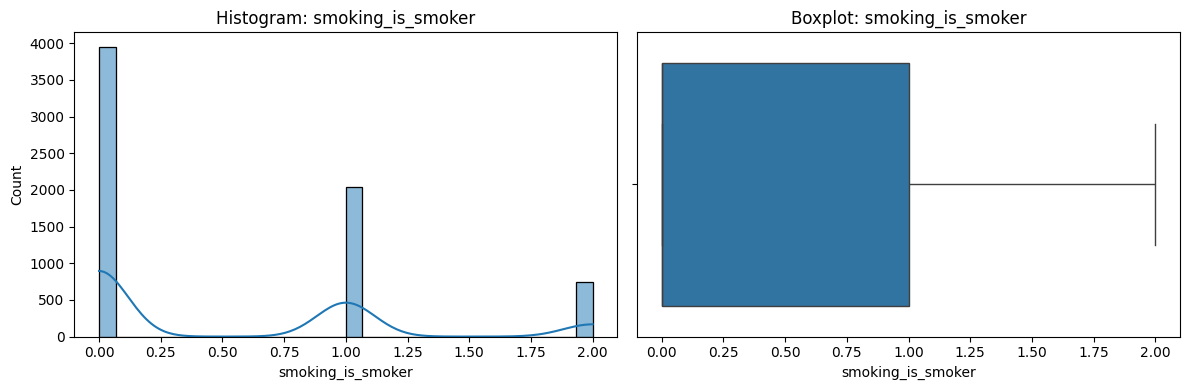

Feature: smoking_smoking_years
Type: float64
Missing: 32.69%
Unique values (1142): [0.   1.86 8.92 7.68 4.53 4.28 2.03 7.41 6.89 7.83] ...
Mean: 4.004, Std: 16.410, Min: 0.0, Max: 122.94
Outliers: 878 (8.78%)
Correlation with Y: 0.001


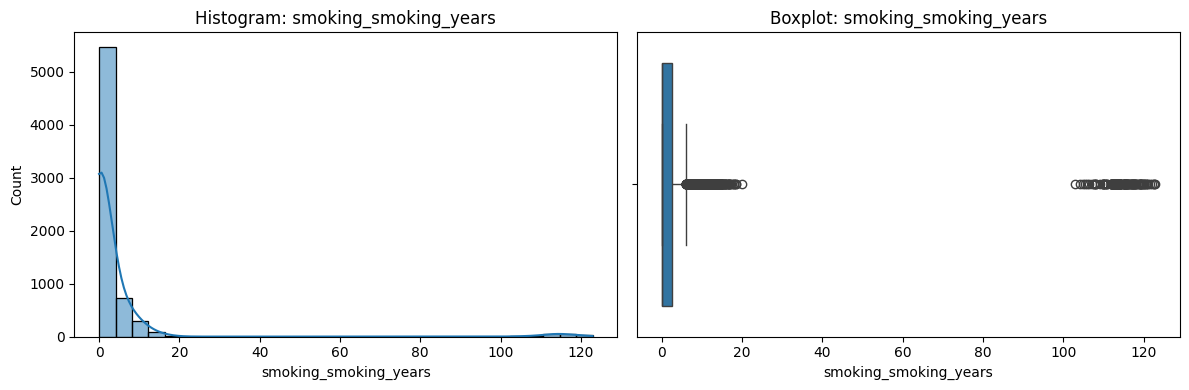

Feature: smoking_total_heavy_smokers
Type: float64
Missing: 32.69%
Unique values (8): [0. 1. 2. 3. 6. 5. 4. 9.]
Mean: 0.013, Std: 0.205, Min: 0.0, Max: 9.0
Outliers: 48 (0.48%)
Correlation with Y: -0.007


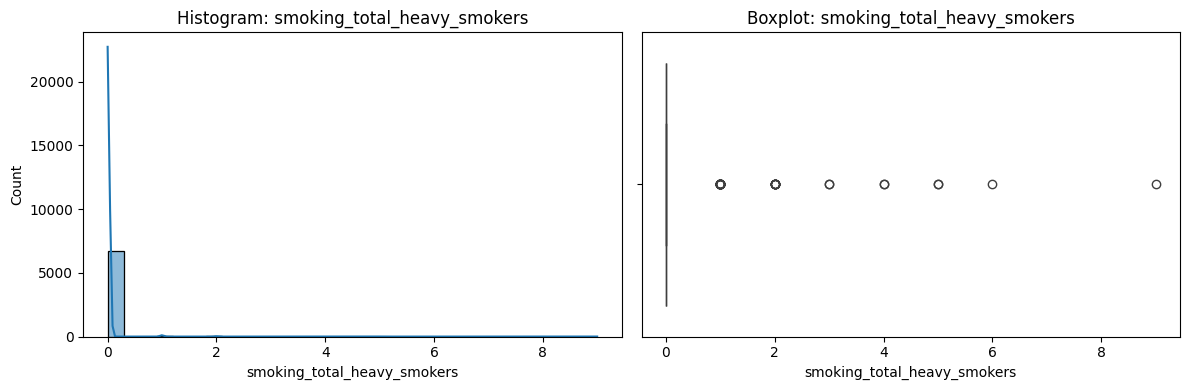

In [ ]:
analyze_feature_group(df, prefix_groups["smoking"])


In [ ]:
df.describe()

,int_date,demog_capitationcoefficient,demog_customer_age,smoking_is_smoker,smoking_smoking_years,smoking_total_heavy_smokers,lab_b_hcg_abs_last_value,lab_NT_MoM_last_value,lab_weight_at_lab_time_last_value,lab_num_of_fetuses_last_value,...,match_aspirin_after,match_pdf_after,Y,essential_hypertension_sum,pregnancy_hypertension_sum,preeclampsia_sum,eclampsia_sum,labs_sum,match_count,match_strength
count,10000.000000,9991.000000,9991.000000,6731.000000,6731.000000,6731.000000,9999.000000,9961.000000,10000.000000,10000.0,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45231.350200,0.720975,29.729657,0.522953,4.004316,0.013074,45.846115,1.041783,63.824700,1.0,...,0.011700,0.011200,0.043200,0.010000,0.011100,0.012800,0.001700,0.004900,0.053200,0.053200
std,26278.437077,0.099963,4.938347,0.684926,16.410500,0.205008,33.349212,0.350041,12.540769,0.0,...,0.107537,0.105241,0.203317,0.099504,0.104775,0.112416,0.041198,0.069832,0.270513,0.270513
min,43.000000,0.430000,16.000000,0.000000,0.000000,0.000000,4.300000,0.110000,36.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22503.250000,0.730000,26.000000,0.000000,0.000000,0.000000,24.800000,0.830000,55.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45409.500000,0.740000,29.000000,0.000000,0.000000,0.000000,37.000000,0.990000,61.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68150.750000,0.770000,33.000000,1.000000,2.415000,0.000000,56.000000,1.200000,70.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,90265.000000,1.180000,51.000000,2.000000,122.940000,9.000000,516.900000,7.860000,152.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000


In [ ]:
df.head(2).T

,0,1
int_date,24163,51373
demog_capitationcoefficient,0.73,0.79
demog_customer_age,33.0,34.0
smoking_is_smoker,0.0,1.0
smoking_smoking_years,0.0,1.86
...,...,...
labs_sum,0,0
clinical_sheet,שבוע 8\n\nתלונות: המטופלת מתלוננת על בחילות בב...,שבוע 8 להיריון\n\nתלונות: המטופלת מתלוננת על ב...
match_count,0,0
no_match,True,True


In [ ]:
df.isnull().sum().sort_values(ascending=False)

,0
4_diag_88_days_since_last_diag,10000
4_diag_90_days_since_last_diag,9999
4_diag_126_days_since_last_diag,9999
4_diag_106_days_since_last_diag,9999
4_diag_136_days_since_last_diag,9999
...,...
labs_sum,0
clinical_sheet,0
match_count,0
no_match,0


In [ ]:
df.isnull().mean().sort_values(ascending=False)

,0
4_diag_88_days_since_last_diag,1.0000
4_diag_90_days_since_last_diag,0.9999
4_diag_126_days_since_last_diag,0.9999
4_diag_106_days_since_last_diag,0.9999
4_diag_136_days_since_last_diag,0.9999
...,...
labs_sum,0.0000
clinical_sheet,0.0000
match_count,0.0000
no_match,0.0000


# Targets Correlations

# Model

In [ ]:
leakage_columns = [
    # Target
    'Y',

    # Post-label source flags
    'match_diag_after',
    'match_measure_after',
    'match_rasham_after',
    'match_aspirin_after',
    'match_pdf_after',

    # Diagnostic subtype counts (all derived from data after prediction point)
    'secondary_hypertension_sum',
    'essential_hypertension_sum',
    'hypertensive_heart_disease_sum',
    'hypertensive_chronic_kidney_disease_sum',
    'hypertensive_heart_and_chronic_kidney_disease_sum',
    'pregnancy_hypertension_sum',
    'preeclampsia_sum',
    'eclampsia_sum',
    'labs_sum',
]


X = df.drop(columns=leakage_columns)

KeyError: "['match_diag_after', 'match_measure_after', 'secondary_hypertension_sum', 'hypertensive_heart_disease_sum', 'hypertensive_chronic_kidney_disease_sum', 'hypertensive_heart_and_chronic_kidney_disease_sum'] not found in axis"